# CAM을 만들고 평가해 보자

## Step 1. 데이터셋 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
# 데이터 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


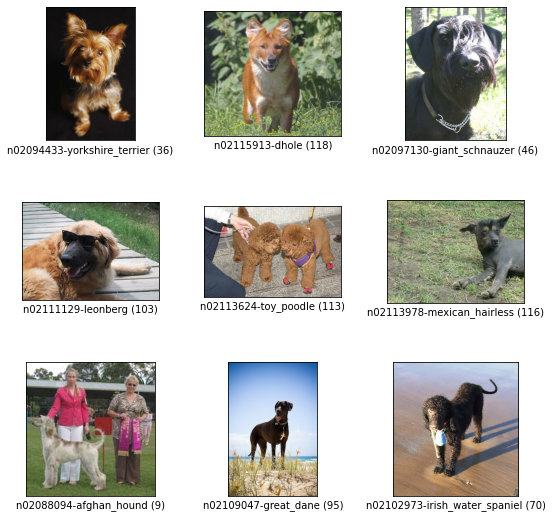

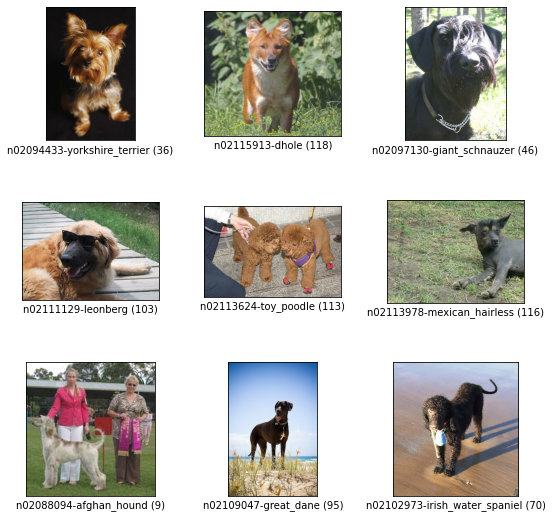

In [3]:
# train set 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_train, ds_info)

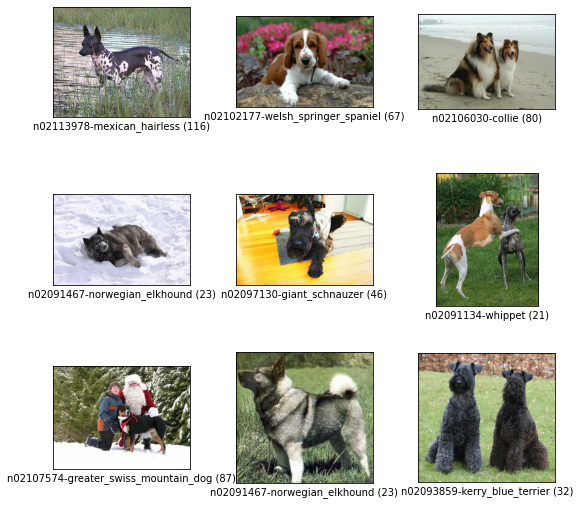

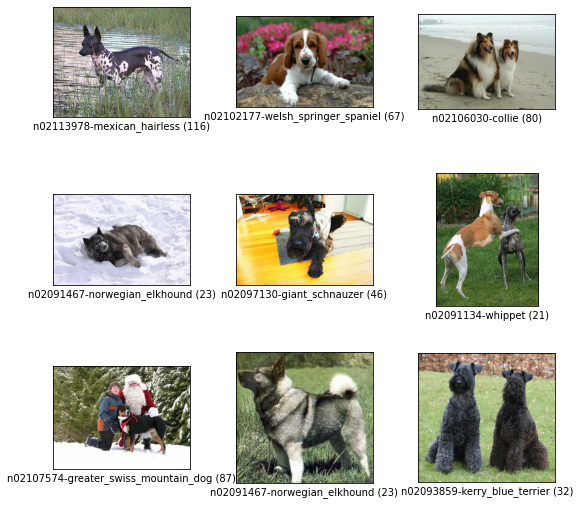

In [4]:
# test set 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_test, ds_info)

In [5]:
# feature 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## Step 2. CAM 구현하기

In [6]:
# CAM 기본모델
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,   # Imagenet 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',   # GAP 적용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
# 전처리 함수
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 배치구성 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양 확인 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
# 학습하기
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=50,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 198s 206ms/step - loss: 2.2465 - accuracy: 0.4398 - val_loss: 3.2851 - val_accuracy: 0.2142
Epoch 2/50
750/750 [==============================] - 158s 211ms/step - loss: 0.6501 - accuracy: 0.8267 - val_loss: 1.1745 - val_accuracy: 0.6550
Epoch 3/50
750/750 [==============================] - 159s 212ms/step - loss: 0.1800 - accuracy: 0.9715 - val_loss: 1.0437 - val_accuracy: 0.7032
Epoch 4/50
750/750 [==============================] - 158s 211ms/step - loss: 0.0588 - accuracy: 0.9962 - val_loss: 0.9578 - val_accuracy: 0.7305
Epoch 5/50
750/750 [==============================] - 158s 211ms/step - loss: 0.0291 - accuracy: 0.9986 - val_loss: 0.9409 - val_accuracy: 0.7379
Epoch 6/50
750/750 [==============================] - 158s 211ms/step - loss: 0.0198 - accuracy: 0.9994 - val_loss: 0.9865 - val_accuracy: 0.7341
Epoch 7/50
750/750 [==============================] - 158s 211ms/step - loss: 0.0152 - accuracy: 0.9993 - val_loss: 0.9850 -

In [11]:
# 학습시킨 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


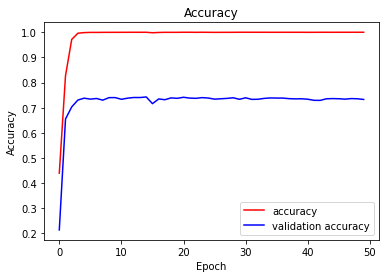

In [12]:
# accuracy 비교
plt.plot(history_cam_model.history['accuracy'], 'r')
plt.plot(history_cam_model.history['val_accuracy'], 'b')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'validation accuracy'], loc='lower right')

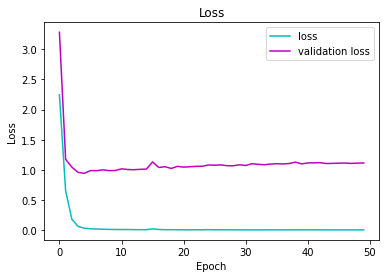

In [13]:
# loss 비교
plt.plot(history_cam_model.history['loss'], 'c')
plt.plot(history_cam_model.history['val_loss'], 'm')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'validation loss'], loc='upper right')

- 50 epoch을 돌렸으나 accuracy를 보면 10 epoch 정도만 진행해도 괜찮을 듯 싶다. 1에 더이상 수렴하지 않고 계속해서 진동하는 것을 봤을 때 많이 학습해도 크게 의미가 없다고 생각한다. loss의 경우 0으로 수렴하고 있지만 validation loss를 봤을 때, 0으로 수렴하지 않고 조금씩 올라가는 양상을 보였다. 노이즈를 많이 학습하는 경우 발생하는 문제로 약간의 overfitting 발생한 거 같다.
- [overfitting](https://webnautes.tistory.com/1648)

In [14]:
# 이미지 하나를 불러오는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

57


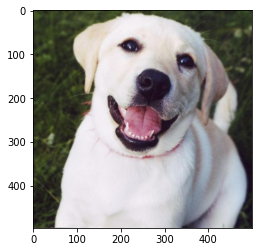

In [17]:
# test 할 이미지 불러오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [18]:
# 학습한 모델 불러오기
cam_model = tf.keras.models.load_model(cam_model_path)

In [19]:
# CAM 생성 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 GAP 이전 Convolution layer의 output을 얻을 수 있다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타난다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

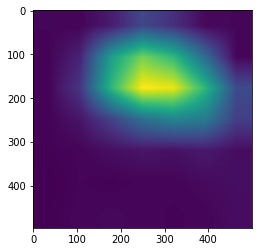

In [20]:
# CAM 얻기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [21]:
# CAM 이미지와 원본 이미지 합치는 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

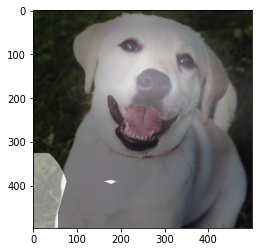

In [22]:
# 합치기 시각화
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Step 3. Grad-CAM 구현하기

In [23]:
# grad-cam 생성 함수
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의한다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값 얻기
        output = conv_output[0] # 원하는 layer의 output 얻기
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient 얻기

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight 구하기
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map 얻기
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

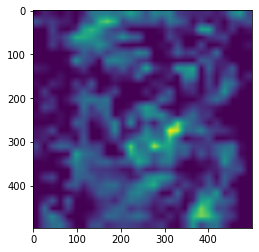

In [24]:
# 여러 레이어의 CAM 이미지 뽑아보기 1
grad_cam_image1 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image1)
plt.show()

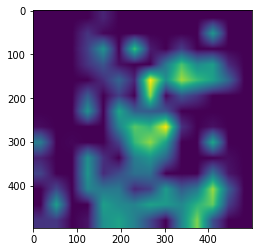

In [25]:
# 여러 레이어의 CAM 이미지 뽑아보기 2
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)
plt.show()

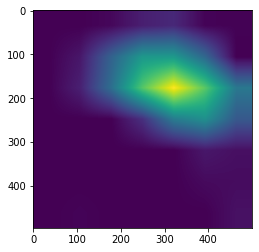

In [26]:
# 여러 레이어의 CAM 이미지 뽑아보기 3
grad_cam_image3 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

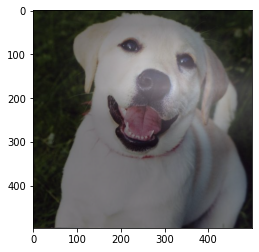

In [27]:
# 합치기 시각화 3
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

## Step 4. 바운딩 박스 구하기

In [28]:
# bbox 만드는 함수
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

### CAM bbox

In [29]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[ 61,   0],
       [499,   0],
       [499, 334],
       [ 61, 334]])

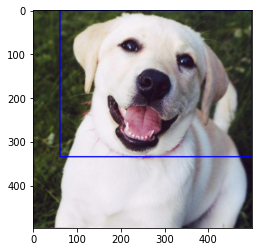

In [30]:
# bbox 시각화
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Grad-CAM bbox

In [31]:
rect_grad = get_bbox(grad_cam_image3)
rect_grad

array([[ 50, 184],
       [202, -89],
       [601, 131],
       [449, 405]])

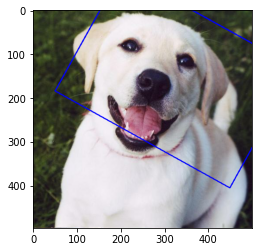

In [32]:
# bbox 시각화
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_grad], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## Step 5. IoU 구하기

In [33]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [34]:
# ground truth bbox
item['objects']['bbox']

array([[0.        , 0.1       , 0.99597585, 0.98      ]], dtype=float32)

In [35]:
# rect_cam를 minmax bbox 형태로 치환하기
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_cam

[0.0, 0.122, 0.6720321931589537, 0.998]

In [36]:
# rect_grad를 minmax bbox 형태로 치환하기
pred_bbox_grad = rect_to_minmax(rect_grad, item['image'])
pred_bbox_grad

[-0.1790744466800805, 0.1, 0.8148893360160966, 1.202]

In [37]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [38]:
# CAM IoU
print(get_iou(pred_bbox_cam, item['objects']['bbox'][0]))

# Grad-CAM IoU
print(get_iou(pred_bbox_grad, item['objects']['bbox'][0]))

0.6489225989690005
0.5715311931613819


----------

## 회고
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정을 보면 accuracy에 있어서는 validation accuracy가 수렴하는 모양새를 보였다. 다만 validation loss가 조금씩 올라가는 양상을 보여 약간의 overfitting이 의심된다.  
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
CAM과 Grad-CAM 방식의 class activation map이 정상적으로 얻어졌지만, CAM의 경우 시각화했을 때 object의 주요 특징 위치를 잘 반영은 했지만 왼쪽 아래쪽이 좀 이상했다. class activation map이 정상적으로 얻어졌는데 시각화 결과가 왜 그렇게 나온건지 모르겠다. Grad-CAM 방식의 경우 시각화가 잘 이루어져 object의 주요 특징 위치를 잘 반영하였다.  
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU계산을 해보았는데, 원본이미지합성의 경우 CAM의 왼쪽 아래부분이 조금 이상하게 나왔다. 바운딩박스의 경우 CAM은 강아지 얼굴을 제대로 잡은 반면, Grad-CAM은 강아지 얼굴을 조금 빗나가서 잡았다. IoU 계산 결과를 봐도 CAM은 0.65, Grad-CAM은 0.57로 CAM의 성능이 좀 더 좋은 것을 알 수 있었다.  
4. 이 프로젝트를 수행하면서 느낀 점: 이번 프로젝트를 통해 CAM과 Grad-CAM에 대해 구조를 좀 더 알 수 있어서 좋았다. 다만, 노드의 내용을 거의 그대로 가져와서 프로젝트를 수행해서 추가적으로 더 할 수 있는 부분을 못찾은 것이 좀 아쉽다.